In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [2]:
import datasets
from transformers import TrainerCallback
from contextlib import nullcontext

from sklearn.metrics import average_precision_score
from torch import nn
from transformers import default_data_collator, Trainer, TrainingArguments



# Load the preprocessed dataset

We load and preprocess the samsum dataset which consists of curated pairs of dialogs and their summarization:

#### 2.1: My Hate Speech Dataset

In [3]:
import pathlib
import numpy as np
import pandas as pd

In [4]:
df_dynGen = pd.read_csv("/bime-munin/xiruod/data/hateSpeech_Bulla2023/Dynamically-Generated-Hate-Speech-Dataset/Dynamically Generated Hate Dataset v0.2.3.csv",)
# df_dynGen['label_binary'] = df_dynGen['label'].map({"hate":1, "nothate":0})

df_dynGen['label'] = df_dynGen['label'].map({"hate":"hate", "nothate":"nothate"})

df_dynGen["dfSource"] = "dynGen"

In [5]:
df_dynGen['label_binary'] = df_dynGen['label'].map({"hate":1,"nothate":0})

In [6]:
ls_allFiles = pathlib.Path("/bime-munin/xiruod/data/hateSpeech_Bulla2023/hate-speech-dataset/all_files/").glob("*.txt")

ls_id = []
ls_text = []

for ifile in ls_allFiles:
    ls_id.append(ifile.name.split(".txt")[0])
    with open(ifile, "r") as f:
        ls_text.append(f.read())

df_wsf_raw = pd.DataFrame({"file_id":ls_id, "text":ls_text})

df_wsf_annotation = pd.read_csv("/bime-munin/xiruod/data/hateSpeech_Bulla2023/hate-speech-dataset/annotations_metadata.csv")

df_wsf = df_wsf_raw.merge(df_wsf_annotation, on="file_id", how="inner")

df_wsf = df_wsf[df_wsf['label'].isin(['hate','noHate'])].reset_index(drop=True)

# df_wsf['label_binary'] = df_wsf['label'].map({"hate":1,"noHate":0})
df_wsf['label'] = df_wsf['label'].map({"hate":"hate","noHate":"nothate"})

df_wsf["dfSource"] = "wsf"

In [7]:
df_wsf['label_binary'] = df_wsf['label'].map({"hate":1,"nothate":0})

### Step 2.2: Split

In [8]:
import sys
import os
import itertools
from tqdm.auto import tqdm

sys.path.append("../src")

from utils import number_split, create_mix

In [9]:
# Hate Speech Detection: df_dynGen (0.55) vs df_wsf (0.11)
n_test = 1000
train_test_ratio = 4


p_pos_train_z0_ls = [0.2, 0.4, 0.5, 0.6, 0.8, 0.9] # probability of training set examples drawn from site/domain z0 being positive
p_pos_train_z1_ls = [0.2, 0.4, 0.5, 0.6, 0.8, 0.9] # probability of test set examples drawn from site/domain z1 being positive

p_mix_z1_ls     = [0.2, 0.4, 0.6, 0.8] # = np.arange(0.1, 0.9, 0.05) 

# alpha_test_ls = np.arange(0, 10, 0.05)

numvals = 1023
base = 1.1
alpha_test_ls = np.power(base, np.arange(numvals))/np.power(base,numvals//2)


valid_full_settings = []
for combination in itertools.product(p_pos_train_z0_ls, 
                                     p_pos_train_z1_ls, 
                                     p_mix_z1_ls,
                                     alpha_test_ls
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [10]:
tmp_df = pd.DataFrame([st['mix_param_dict'] for st in valid_full_settings])

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

/home/NETID/xiruod/anaconda3/envs/llama2/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/NETID/xiruod/anaconda3/envs/llama2/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='p_pos_test_z0', ylabel='p_pos_test_z1'>

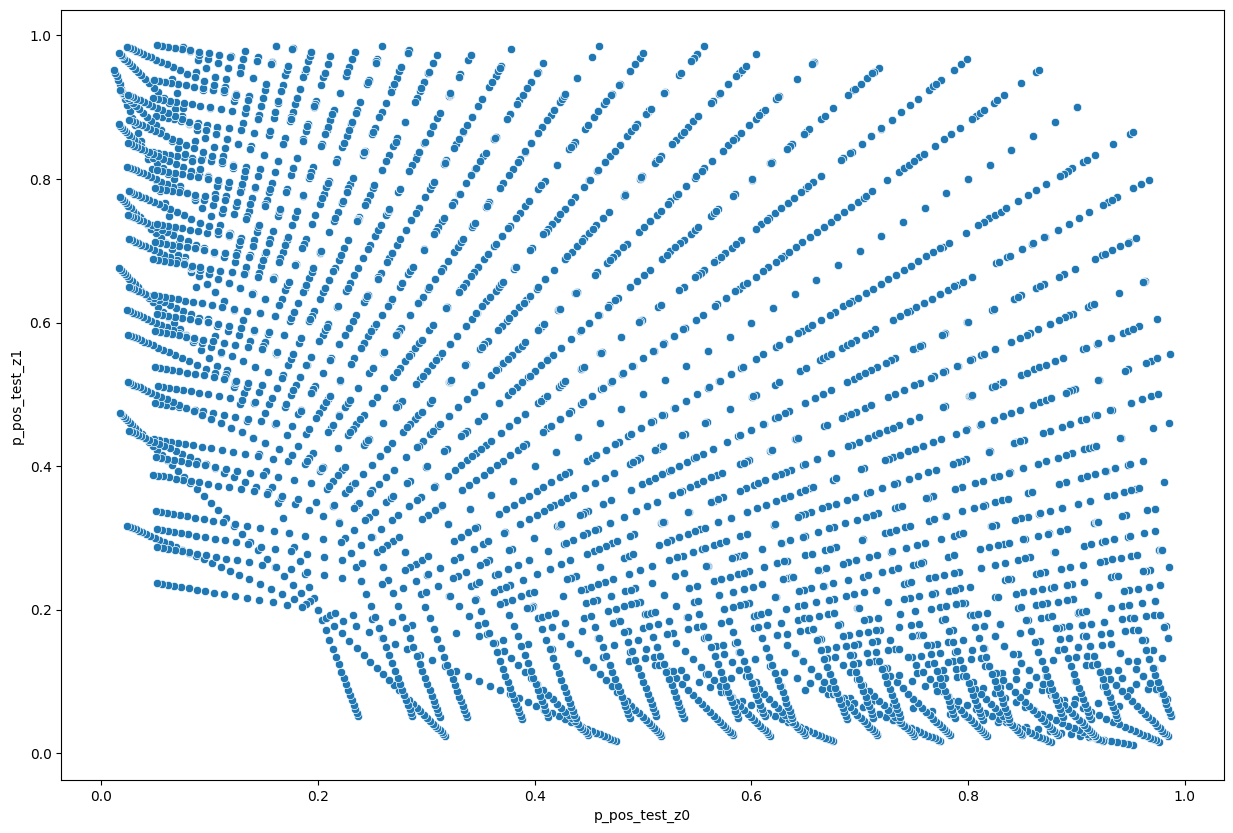

In [12]:
plt.figure(figsize=(15,10))
sns.scatterplot(x="p_pos_test_z0", y="p_pos_test_z1", data=tmp_df)

In [13]:
# run for check valid settings

import warnings; warnings.simplefilter('ignore')

label='label_binary'
df0 = df_dynGen
df1 = df_wsf


valid_n_full_settings = []

for c in tqdm(valid_full_settings):
    # for c in test_settings:


        c = c.copy()
        # create train/test split according to stats
        # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
        # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
        dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                         # seed=random.randint(0,1000),
                         seed=222
                        )

        if dfs is None:
            continue
        
        valid_n_full_settings.append(c)

  0%|          | 0/5642 [00:00<?, ?it/s]

In [14]:
len(valid_n_full_settings)

3194

In [15]:
tmp_df = pd.DataFrame([st['mix_param_dict'] for st in valid_n_full_settings])

<Axes: xlabel='p_pos_test_z0', ylabel='p_pos_test_z1'>

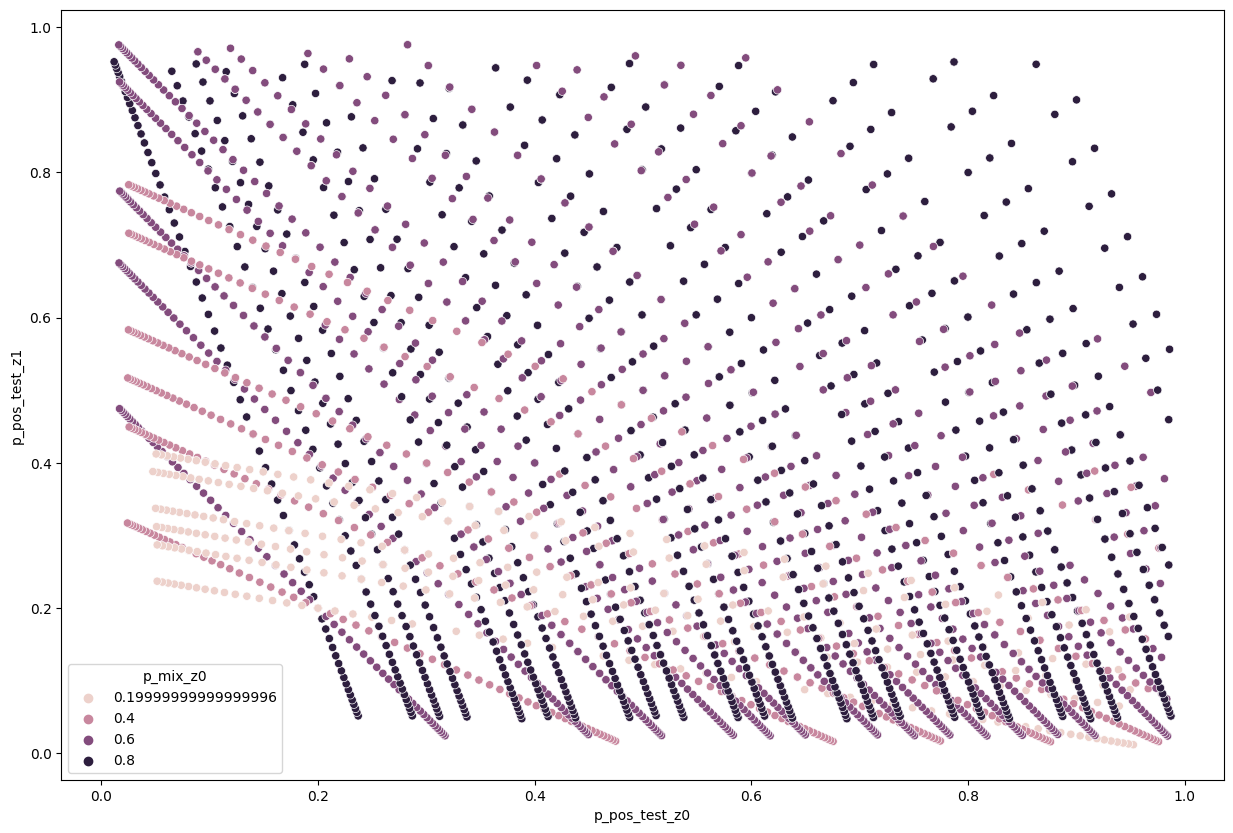

In [16]:
plt.figure(figsize=(15,10))
sns.scatterplot(x="p_pos_test_z0", y="p_pos_test_z1", hue="p_mix_z0", data=tmp_df)

<Axes: xlabel='p_pos_test_z0', ylabel='p_pos_test_z1'>

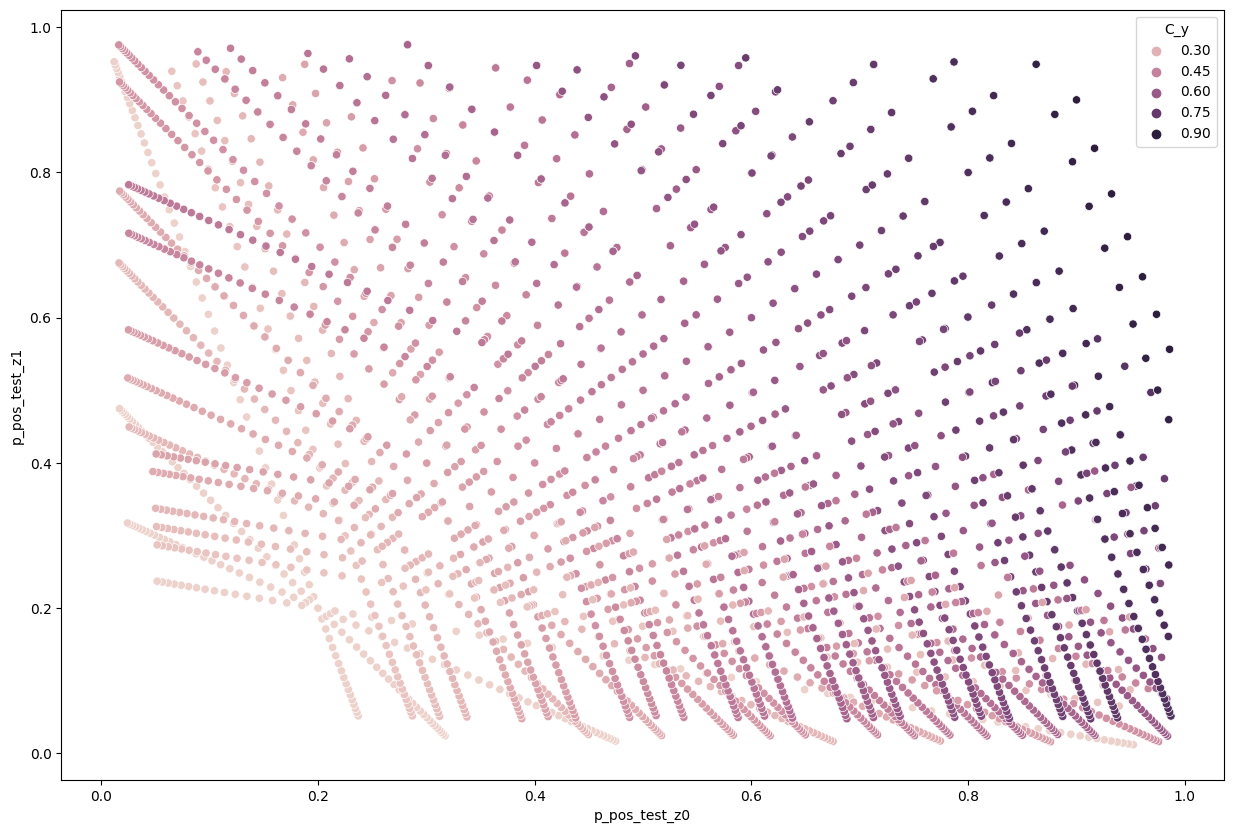

In [17]:
plt.figure(figsize=(15,10))
sns.scatterplot(x="p_pos_test_z0", y="p_pos_test_z1", hue="C_y", data=tmp_df)

In [18]:
tmp_df['C_y'].unique()

array([0.2 , 0.2 , 0.24, 0.28, 0.32, 0.26, 0.36, 0.32, 0.34, 0.36, 0.24,
       0.4 , 0.4 , 0.42, 0.44, 0.44, 0.48, 0.48, 0.5 , 0.38, 0.48, 0.46,
       0.5 , 0.52, 0.54, 0.56, 0.58, 0.58, 0.6 , 0.64, 0.66, 0.68, 0.72,
       0.74, 0.68, 0.76, 0.72, 0.8 , 0.82, 0.62, 0.34, 0.8 , 0.7 , 0.6 ,
       0.82, 0.74, 0.84, 0.78, 0.88, 0.9 ])

In [19]:
tmp_df.query("C_y == 0.48")['alpha_train'].unique()

array([1.5       , 0.66666667])

In [20]:
tmp_df.query("C_y == 0.48").sort_values("alpha_test")

,p_pos_train_z0,p_pos_train_z1,p_pos_train,p_pos_test,p_mix_z0,p_mix_z1,alpha_train,alpha_test,p_pos_test_z0,p_pos_test_z1,C_y,C_z
1226,0.4,0.6,0.48,0.48,0.6,0.4,1.500000,0.032349,0.783111,0.025333,0.48,0.4
1227,0.4,0.6,0.48,0.48,0.6,0.4,1.500000,0.035584,0.781462,0.027808,0.48,0.4
1228,0.4,0.6,0.48,0.48,0.6,0.4,1.500000,0.039143,0.779655,0.030518,0.48,0.4
1229,0.4,0.6,0.48,0.48,0.6,0.4,1.500000,0.043057,0.777677,0.033484,0.48,0.4
1230,0.4,0.6,0.48,0.48,0.6,0.4,1.500000,0.047362,0.775513,0.036730,0.48,0.4
1231,0.4,0.6,0.48,0.48,0.6,0.4,1.500000,0.052099,0.773147,0.040280,0.48,0.4
1232,0.4,0.6,0.48,0.48,0.6,0.4,1.500000,0.057309,0.770560,0.044160,0.48,0.4
1233,0.4,0.6,0.48,0.48,0.6,0.4,1.500000,0.063039,0.767735,0.048398,0.48,0.4
1234,0.4,0.6,0.48,0.48,0.6,0.4,1.500000,0.069343,0.764651,0.053023,0.48,0.4
1235,0.4,0.6,0.48,0.48,0.6,0.4,1.500000,0.076278,0.761287,0.058069,0.48,0.4


In [1]:
# 1244, 2234 -> 0.1798
# 1256, 2246 -> 0.5644
# 1249, 2239 -> 0.2896
# 1257, 2247 -> 0.6209
# 1251, 2241 -> 0.3504

# 1253, 2243 -> 0.4240

# 1255, 2245 -> 0.5131
# 1247, 2237 -> 0.2393
# 1254, 2244 -> 0.4665

# 

In [14]:
valid_n_full_settings[2241]

{'n_train': 4000,
 'n_test': 1000,
 'n_z0_pos_train': 960,
 'n_z0_neg_train': 640,
 'n_z0_pos_test': 315,
 'n_z0_neg_test': 85,
 'n_z1_pos_train': 960,
 'n_z1_neg_train': 1440,
 'n_z1_pos_test': 165,
 'n_z1_neg_test': 435,
 'mix_param_dict': {'p_pos_train_z0': 0.6,
  'p_pos_train_z1': 0.4,
  'p_pos_train': 0.48,
  'p_pos_test': 0.48,
  'p_mix_z0': 0.4,
  'p_mix_z1': 0.6,
  'alpha_train': 0.6666666666666667,
  'alpha_test': 0.3504938994813922,
  'p_pos_test_z0': 0.786503160488775,
  'p_pos_test_z1': 0.27566455967415,
  'C_y': 0.48,
  'C_z': 0.6}}

# Configs

In [22]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [4]:
import torch
from transformers import LlamaTokenizer, LlamaForSequenceClassification, LlamaConfig


In [5]:
class train_config:
    def __init__(self):
        self.quantization: bool = False

    

In [6]:
globalconfig = train_config()

In [7]:
globalconfig.quantization = True

In [8]:
globalconfig.device = "cuda:0"

In [9]:
globalconfig.profiler = False

In [10]:
globalconfig.output_dir = "/bime-munin/xiruod/tmp/quantized_epoch3-llama-output"

In [11]:
globalconfig.model_id="/bime-munin/llama2_hf/llama-2-7b_hf/"

In [12]:
globalconfig.max_seq_length=1024

In [13]:
globalconfig.num_train_epochs=3

In [14]:
globalconfig.runs=1

In [17]:
tokenizer = LlamaTokenizer.from_pretrained(globalconfig.model_id)


In [20]:
tokenizer = LlamaTokenizer.from_pretrained(globalconfig.model_id)


tokenizer.add_special_tokens({"pad_token":"<pad>"}) 

1

In [30]:
tokenizer.special_tokens_map_extended

{'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False),
 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False),
 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False),
 'pad_token': '<pad>'}

In [21]:
tokenizer

LlamaTokenizer(name_or_path='/bime-munin/llama2_hf/llama-2-7b_hf/', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False)

In [22]:
len(tokenizer)

32001

In [23]:
z_category = ['nothate', 'hate']

label2id = {z:idx for idx,z in zip(range(len(z_category)), z_category)}
id2label = {idx:z for idx,z in zip(range(len(z_category)), z_category)}

# Datasets loader and Tokenize

In [24]:
def preprocess_function(examples):

    return  tokenizer(examples['text'], return_tensors='pt', max_length=globalconfig.max_seq_length, padding='max_length', truncation=True).to(globalconfig.device)


def datasets_loader(df):
    ret_datasets = datasets.Dataset.from_pandas(df[['text','dfSource','label_binary']].rename(columns={"label_binary":"label"}).reset_index(drop=True))

    ret_tokenized = ret_datasets.map(preprocess_function, batched=True)

    return ret_tokenized

# Experiment: One setting

In [37]:
pick_C = 9
c = valid_n_full_settings[pick_C]

dfs =  dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                         # seed=random.randint(0,1000),
                         seed=222
                        )

In [38]:
tokenized_train = datasets_loader(dfs['train'])

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [39]:
tokenized_test = datasets_loader(dfs['test'])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [40]:
## Define metric
def compute_metrics_twoLevels(eval_pred):

    predictions, labels = eval_pred
    probabilities = nn.functional.softmax(torch.FloatTensor(predictions), dim=-1)[:,1]

    auprc = average_precision_score(y_true=labels, y_score=probabilities)

    return {"auprc":auprc}

In [43]:
## Initialize model
model = LlamaForSequenceClassification.from_pretrained(globalconfig.model_id, 
                                         load_in_8bit=globalconfig.quantization, 
                                         device_map="cuda:0", 
                                                       torch_dtype=torch.float16 if globalconfig.quantization else torch.float32,
                                                       num_labels = len(id2label), 
                                                       id2label=id2label,
                                                       label2id=label2id,
                                        )


model.config.pad_token_id = tokenizer.pad_token_id

model.resize_token_embeddings(len(tokenizer))

model.train()

## Peft Config
def create_peft_config(model):
    from peft import (
        get_peft_model,
        LoraConfig,
        TaskType,
        prepare_model_for_int8_training,
    )

    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=8,
        bias="none",
        lora_alpha=32,
        lora_dropout=0.05,
        target_modules = ["q_proj", "v_proj"],
        modules_to_save=["classifier"],
    )

    # prepare int-8 model for training
    if globalconfig.quantization:
        model = prepare_model_for_int8_training(model)
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()
    return model, peft_config

model, lora_config = create_peft_config(model)

## Profiler

enable_profiler = globalconfig.profiler
output_dir = globalconfig.output_dir

config = {
    'lora_config': lora_config,
    'learning_rate': 1e-5,
    'num_train_epochs': globalconfig.num_train_epochs,
    'gradient_accumulation_steps': 2,
    'per_device_train_batch_size': 2,
    'gradient_checkpointing': False,
    'warmup_ratio':0.1,
}

# Set up profiler
if enable_profiler:
    # wait, warmup, active, repeat = 1, 1, 2, 1
    wait, warmup, active, repeat = 10, 10, 100, 1
    total_steps = (wait + warmup + active) * (1 + repeat)
    schedule =  torch.profiler.schedule(wait=wait, warmup=warmup, active=active, repeat=repeat)
    profiler = torch.profiler.profile(
        schedule=schedule,
        on_trace_ready=torch.profiler.tensorboard_trace_handler(f"{output_dir}/logs/tensorboard"),
        record_shapes=True,
        profile_memory=True,
        with_stack=True)
    
    class ProfilerCallback(TrainerCallback):
        def __init__(self, profiler):
            self.profiler = profiler
            
        def on_step_end(self, *args, **kwargs):
            self.profiler.step()

    profiler_callback = ProfilerCallback(profiler)
else:
    profiler = nullcontext()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at /bime-munin/llama2_hf/llama-2-7b_hf/ and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32001. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


trainable params: 4,210,688 || all params: 6,611,558,400 || trainable%: 0.06368677012669206


In [44]:
# Define training args
training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    bf16=globalconfig.quantization,  # Use BF16 if available
    # logging strategies
    logging_dir=f"{output_dir}/logs",
    logging_strategy="steps",
    logging_steps=10,
    save_strategy="no",
    optim="adamw_torch_fused" if globalconfig.quantization else "adamw_torch",
    max_steps=total_steps if enable_profiler else -1,
    # max_steps=50,

    **{k:v for k,v in config.items() if k != 'lora_config'}
)

In [ ]:
with profiler:
    # Create Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        data_collator=default_data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_twoLevels,
        callbacks=[profiler_callback] if enable_profiler else [],
    )

    # Start training
    ret_train = trainer.train()
    ret_eval = trainer.evaluate()

# save metrics
ret = c
ret.update(ret_eval)
ret.update(ret_train.metrics)
trainer.save_metrics(split="all", metrics=ret)

ret_code = 1

In [37]:
ret_code

1

In [38]:
model.save_pretrained(output_dir)

In [39]:
ret

{'n_train': 4000,
 'n_test': 1000,
 'n_z0_pos_train': 640,
 'n_z0_neg_train': 2560,
 'n_z0_pos_test': 177,
 'n_z0_neg_test': 623,
 'n_z1_pos_train': 160,
 'n_z1_neg_train': 640,
 'n_z1_pos_test': 23,
 'n_z1_neg_test': 177,
 'mix_param_dict': {'p_pos_train_z0': 0.2,
  'p_pos_train_z1': 0.2,
  'p_pos_train': 0.20000000000000004,
  'p_pos_test': 0.20000000000000004,
  'p_mix_z0': 0.8,
  'p_mix_z1': 0.2,
  'alpha_train': 1.0,
  'alpha_test': 0.5131581182307065,
  'p_pos_test_z0': 0.2215743330508505,
  'p_pos_test_z1': 0.11370266779659827,
  'C_y': 0.20000000000000004,
  'C_z': 0.2},
 'eval_loss': 0.757780134677887,
 'eval_auprc': 0.233621572706505,
 'eval_runtime': 807.1465,
 'eval_samples_per_second': 1.239,
 'eval_steps_per_second': 0.155,
 'epoch': 1.0,
 'train_runtime': 6887.9188,
 'train_samples_per_second': 0.581,
 'train_steps_per_second': 0.145,
 'total_flos': 1.59264333103104e+17,
 'train_loss': 0.8231853125095367}

In [40]:
ret_eval

{'eval_loss': 0.757780134677887,
 'eval_auprc': 0.233621572706505,
 'eval_runtime': 807.1465,
 'eval_samples_per_second': 1.239,
 'eval_steps_per_second': 0.155,
 'epoch': 1.0}